In [1]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

import os
import yaml
import wandb
from tqdm import tqdm
from typing import List, Tuple, Callable

import numba
from numba import njit

from keras.datasets import fashion_mnist

## Ques 1 : Loading the Dataset and plotting them

In [2]:
# Loading the dataset
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

# mapping from label to class name
fashion_mnist_label_to_class = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

fashion_mnist_train_df = pd.DataFrame({"image" : list(fashion_mnist_x_train), "label" : fashion_mnist_y_train})
fashion_mnist_test_df = pd.DataFrame({"image" : list(fashion_mnist_x_test), "label" : fashion_mnist_y_test})

print(f"Shape of the train fashion mnist : {fashion_mnist_x_train.shape}")
print(f"Shape of the test fashion mnist : {fashion_mnist_x_test.shape}")

Shape of the train fashion mnist : (60000, 28, 28)
Shape of the test fashion mnist : (10000, 28, 28)


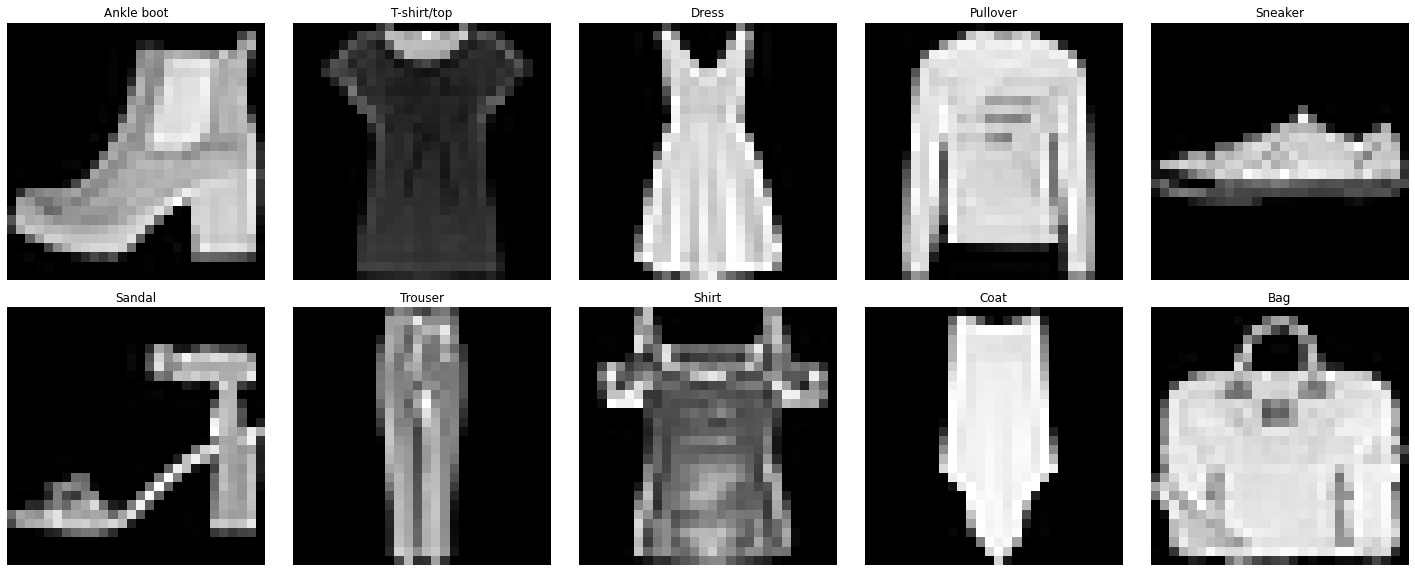

In [3]:
def plot_imag_for_a_label(df):
    unique_labels = df["label"].unique()

    # creating a figure for subplots
    cols = 5
    rows = (len(unique_labels) // (cols)) + 1
    plt.figure(figsize=(20, 12))

    for i, label in enumerate(unique_labels):
        image = df[df["label"] == label].sample(1)["image"]

        # plotting the image
        plt.subplot(rows, cols, i+1)
        plt.imshow(image.values[0], cmap="gray")
        plt.title(fashion_mnist_label_to_class[label])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_imag_for_a_label(fashion_mnist_train_df)

## Ques 2 and Ques 3 : Creating a neural Network

In [4]:
"""
Coding Logic :

    - Similar to PyTorch (Kind of)

    - vectors : 
        - (1,n) dim (column vectors)
        - (batch size, dimension)

    - matrix :
        - (n,m) dimension 
        - matrix multiplication: (batch_size, n) x (n,m) -> (batch_size, m) vector
    
    - Each layer is a class
        - layer can be activation or parameter
        - each layer has a name
        - each layer is identified by the name

"""

'\nCoding Logic :\n\n    - Similar to PyTorch (Kind of)\n\n    - vectors : \n        - (1,n) dim (column vectors)\n        - (batch size, dimension)\n\n    - matrix :\n        - (n,m) dimension \n        - matrix multiplication: (batch_size, n) x (n,m) -> (batch_size, m) vector\n    \n    - Each layer is a class\n        - layer can be activation or parameter\n        - each layer has a name\n        - each layer is identified by the name\n\n'

In [5]:
def xavier_init(n_in, n_out):
    """ Xavier (Glorot) Initialization """
    limit = np.sqrt(6 / (n_in + n_out))  # Computing the limit
    return np.random.uniform(-limit, limit, size=(n_in, n_out)).astype(np.float64)

def random_init_uniform(n_in, n_out):
    """ Random Initialization (Uniform) """
    return np.random.uniform(-1, 1, size=(n_in, n_out)).astype(np.float64)

In [6]:
x = np.array([[1,2,3],[1,2,3]])
# x = x.reshape(1,-1)
# np.hstack([x,np.array([[1]])])
np.concatenate( [x,np.ones(shape = (x.shape[0],1), dtype = np.float64)] , axis = 1)

array([[1., 2., 3., 1.],
       [1., 2., 3., 1.]])

### Linear layer

In [7]:
class Layer_Info():
    @property
    def is_activation(self): 
        return self._is_activation

    @property
    def layer_name(self):
        return self._name

    @property
    def layer_type(self):
        return self._layer_type

@njit
def matrix_mul(x,y):
    x = np.ascontiguousarray(x)
    y = np.ascontiguousarray(y) 
    return x@y

class Linear(Layer_Info):
    def __init__(self, input_dim : int, 
                       output_dim : int, 
                       initializer_function : Callable = xavier_init,
                       bias : bool = True,
                       name = "default_name"):

        # getting the weights of the network (adding one more input for bias)
        self.input_dim = input_dim + int(bias)
        self.output_dim = output_dim
        self.w = initializer_function(self.input_dim, self.output_dim)

        # other necessary variables for the info the layer
        self.is_bias = bias
        self._name = name
        self._layer_type = "Linear"
        self._is_activation = False

        # variables for gradients and used by optimizers
        self.dw = np.zeros(shape = self.w.shape, dtype = np.float64)
        self.optimizer_variables = {} # -> This is important thing used used by the optimizers for updating the weights
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # changing the dtype and adding the input for the bias
        self.x = x.astype(np.float64)
        if self.is_bias: self.x = np.concatenate((self.x,np.ones(shape = (x.shape[0],1), dtype = np.float64)), axis = 1)

        # returning the matrix multiplication
        # raise Exception(f"""Test 1 : print under forward of linear , input_shape : {self.x.shape} , weight_shape : {self.w.shape}
        #                 output_shape : {(self.x@self.w).shape}""") # -> Test passed
    
        # return self.x@self.w
        return matrix_mul(self.x,self.w)
        
    def backward(self, prev_grad : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # updating the gradient for weights and x
        # self.dw = self.x.T@prev_grad
        # self.dx = prev_grad@self.w.T
        self.dw = matrix_mul(self.x.T,prev_grad)
        self.dx = matrix_mul(prev_grad,self.w.T)
        if self.is_bias: self.dx = self.dx[:,:-1] #( We have to remove the extra bias term we have added for calculation)

        # this will be used by the optimizer
        self.optimizer_variables['dw'] = self.dw
        self.optimizer_variables['dx'] = self.dx

        return self.dx
    
    def step(self, optimizer):
        # for updating the values
        optimizer.update_params(self)

In [8]:
linear_layer = Linear(10,20,xavier_init)
linear_layer.forward(np.ones((15,10))).shape
linear_layer.backward(np.ones((15,20))).shape

(15, 10)

### Activation functions

In [9]:
class Sigmoid(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._layer_type = "Sigmoid"
        self._is_activation = True
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # for numerical stability
        self.x = x
        x = np.clip(x, -100, 100)
        self.output = np.where( x >= 0, 1 / (1 + np.exp(-x)),  np.exp(x) / (1 + np.exp(x)) )
        # raise Exception(f"Test 2 : Inside the sigmoid act fn , output shape : {self.output.shape}") 
        return self.output

    def backward(self, prev_grad : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # updating the gradient for x (using hadamard product)
        self.dx = prev_grad*self.output*(1 - self.output)
        return self.dx
    

class Tanh(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._layer_type = "Tanh"
        self._is_activation = True
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # for numerical stability
        self.x = x
        self.output = np.tanh(self.x)
        # self.output = np.where( x >= 0, (1 - np.exp(-2*x))/(np.exp(-2*x) + 1),  (np.exp(2*x) - 1)/(1 + np.exp(2*x)) )
        # raise Exception(f"Test 3 : Inside the Tanh act fn , output shape : {self.output.shape}")
        return self.output

    def backward(self, prev_grad : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        # updating the gradient for x (using hadamard product)
        self.dx = prev_grad*(1 - self.output**2)
        return self.dx

class ReLU(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._layer_type = "ReLU"
        self._is_activation = True
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # for numerical stability
        self.x = x
        self.output = np.maximum(x,0)
        # raise Exception(f"Test 4 : Inside the ReLU act fn , output shape : {self.output.shape}") # -> passed
        return self.output

    def backward(self, prev_grad : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        # updating the gradient for x (using hadamard product)
        self.dx = prev_grad*(self.output > 0)
        return self.dx

In [10]:
sig = Sigmoid()
x = np.random.randint(-1,100000,size = (15,10)).astype(np.float64)
sig.forward(x)
sig.backward(np.ones(shape = (15,10))).shape

(15, 10)

In [11]:
# gr = -1000000000
# (np.exp(2*gr) - 1) / (1 + np.exp(2*gr))

# for i in x:
#         for j in i:
#                 np.where( j >= 0,
#                         (1 - np.exp(-2*j)) / (np.exp(-2*j) + 1),  
#                         (np.exp(2*j) - 1) / (1 + np.exp(2*j))   
#                         )
#                 print(j)
# np.where( j >= 0,
#         -10,  
#         (np.exp(2*j) - 1) / (1 + np.exp(2*j))   
#         )

np.tanh(x)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

### Loss functions

In [12]:
class softmax_cross_entropy(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._is_activation = False
        self._layer_type = "Softmax-with-Cross-Entropy"
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # for numerical stability
        self.x = x
        x_max = np.max(x, axis=1, keepdims=True)  # size -> (batch_size, 1)
        exp_x = np.exp(x - x_max)  # Subtract max for numerical stability
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True) # normalizing along the axis
        # raise Exception(f"Test 5 : Inside the Softmax Cross entropy , output shape : {self.output.shape}") # -> passed
        return self.output

    def calculate_loss(self, y_true : npt.NDArray[np.float64]) -> float:
        self.loss = np.sum(-np.log(self.output + 1e-10)*y_true, axis = 1)
        return np.mean(self.loss)

    def backward(self, y_true : npt.NDArray[np.float64]) -> npt.NDArray[np.float64] :
        self.dx = -(y_true - self.output)
        return self.dx

class L2_Loss(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._is_activation = False
        self._layer_type = "L2-Loss"
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        self.x = x
        self.output = self.x.copy()
        return self.output

    def calculate_loss(self, y_true : npt.NDArray[np.float64]) -> float:
        self.loss = np.mean((y_true - self.output)**2, axis = 1)
        return np.mean(self.loss)

    def backward(self, y_true : npt.NDArray[np.float64])  -> npt.NDArray[np.float64] :
        self.dx = -(y_true - self.output)
        return self.dx

class Sigmoid_with_BCE(Layer_Info):
    def __init__(self, name = "default_name"):
        self._name = name
        self._is_activation = False
        self._layer_type = "Softmax-with-Cross-Entropy"
    
    def forward(self, x : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        raise NotImplementedError("Question didn't ask for it, so haven't implemented, just defined for namesake")

    def backward(self, y_true : npt.NDArray[np.float64])  -> npt.NDArray[np.float64] :
        raise NotImplementedError("Question didn't ask for it, so haven't implemented, just defined for namesake")

In [13]:
softmax_test = L2_Loss()
softmax_test.forward(np.random.normal(size = (5,10)))
fake_true = np.random.randint(0,2, size = (5,10))
softmax_test.calculate_loss(y_true = fake_true)

1.8376637622295313

### optimizers

In [14]:
class optimizer_info():
    @property
    def learning_rate(self):
        return self.lr

    @property
    def optimizer_type(self):
        return self._optimizer_type

    @property
    def optimizer_name(self):
        return self._name
    
    @property
    def specification(self):
        return self._specification

    def __str__(self):
        s = f"These are the specifications of the optimizer : '{self._optimizer_type}' \n"
        s += "\n".join([f"{str(x)} : {str(y)}" for x,y in self._specification.items()])
        return s

class SGD(optimizer_info):
    def __init__(self, lr : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        self._name = name
        self._optimizer_type = "SGD"

        self.lr = lr
        self.weight_decay = weight_decay

        self._specification = {"lr" : lr, "weight_decay": weight_decay} # This will tell what are the specifications of different optimizers
    
    def update_params(self, obj : Linear):

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w

        # updating the parameters here
        obj.w -= self.lr*dw

class GD_Momentum(optimizer_info):
    def __init__(self, lr : float, 
                       beta : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "GD_with_Momentum"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta = beta

        self._specification = {"lr" : self.lr, "beta" : self.beta, "weight_decay" : weight_decay,
                               "du" : "previous gradients updates for momentum"} # This will tell what are the specifications of different optimizers
    
    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']
        if "du" not in obj.optimizer_variables: 
            obj.optimizer_variables['du'] = np.zeros(shape = dw.shape, dtype = np.float64)
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        ut = (self.beta)*obj.optimizer_variables['du'] + dw

        # updating the parameters here and optimizer variables
        obj.w -= self.lr*ut
        obj.optimizer_variables['du'] = ut

class NAG(optimizer_info):
    def __init__(self, lr : float, 
                       beta : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "NAG"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta = beta

        self._specification = {"lr" : self.lr, "beta" : self.beta, "weight_decay" : weight_decay, "du" : "previous gradients updates for momentum"} # This will tell what are the specifications of different optimizers
    
    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']
        if "du" not in obj.optimizer_variables: 
            obj.optimizer_variables['du'] = np.zeros(shape = dw.shape, dtype = np.float64)
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        ut = (self.beta)*obj.optimizer_variables['du'] + dw

        # updating the parameters here and optimizer variables
        obj.w += -(self.lr*dw) - (self.lr*self.beta*ut)
        obj.optimizer_variables['du'] = ut

class RMSprop(optimizer_info):
    def __init__(self, lr : float, 
                       beta : float,
                       epsilon : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "RMSprop"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta = beta
        self.epsilon = epsilon

        self._specification = {"lr" : self.lr, 
                               "beta" : self.beta, 
                               "epsilon" : self.epsilon,
                               "weight_decay" : weight_decay,
                               "dv" : "cumulative square of gradients"} # This will tell what are the specifications of different optimizers

    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']
        if "dv" not in obj.optimizer_variables: 
            obj.optimizer_variables['dv'] = np.zeros(shape = dw.shape, dtype = np.float64)
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        vt = (self.beta)*obj.optimizer_variables['dv'] + (1 - self.beta)*(dw**2)

        # updating the parameters here and optimizer variables
        obj.w -= (self.lr)*(dw)/((vt + self.epsilon)**0.5)
        obj.optimizer_variables['dv'] = vt

class Adam(optimizer_info):
    def __init__(self, lr : float, 
                       beta1 : float,
                       beta2 : float,
                       epsilon : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "Adam"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self._specification = {"lr" : self.lr, 
                               "beta1" : self.beta1, 
                               "beta2" : self.beta2,
                               "epsilon" : self.epsilon,
                               "weight_decay" : weight_decay,
                               "dm" : "classical momentum",
                               "dv" : "cumulative square of gradients"} # This will tell what are the specifications of different optimizers
    
    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']

        if "dv" not in obj.optimizer_variables: 
            obj.optimizer_variables['dv'] = np.zeros(shape = dw.shape, dtype = np.float64)

        if "dm" not in obj.optimizer_variables: 
            obj.optimizer_variables['dm'] = np.zeros(shape = dw.shape, dtype = np.float64)
        
        if "beta1^t" not in obj.optimizer_variables:
            obj.optimizer_variables['beta1^t'] = self.beta1

        if "beta2^t" not in obj.optimizer_variables:
            obj.optimizer_variables['beta2^t'] = self.beta2
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        mt = (self.beta1)*obj.optimizer_variables['dm'] +  (1 - self.beta1)*(dw)
        vt = (self.beta2)*obj.optimizer_variables['dv'] + (1 - self.beta2)*(dw**2)
        beta1_t = obj.optimizer_variables['beta1^t']
        beta2_t = obj.optimizer_variables['beta2^t']

        mt_normalized = mt/(1 - beta1_t)
        vt_normalized = vt/(1 - beta2_t)

        # updating the parameters here and optimizer variables
        obj.w -= (self.lr)*(mt_normalized)/((vt_normalized**0.5) + self.epsilon)

        obj.optimizer_variables['dv'] = vt
        obj.optimizer_variables['dm'] = mt
        obj.optimizer_variables['beta1^t'] = self.beta1*beta1_t
        obj.optimizer_variables['beta2^t'] = self.beta2*beta2_t

class Nadam(optimizer_info):
    def __init__(self, lr : float, 
                       beta1 : float,
                       beta2 : float,
                       epsilon : float,
                       weight_decay : float,
                       name = "default_name", **kwargs):
        
        self._name = name
        self._optimizer_type = "Nadam"

        self.lr = lr
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self._specification = {"lr" : self.lr, 
                               "beta1" : self.beta1, 
                               "beta2" : self.beta2,
                               "epsilon" : self.epsilon,
                               "weight_decay" : weight_decay,
                               "dm" : "classical momentum",
                               "dv" : "cumulative square of gradients"} # This will tell what are the specifications of different optimizers
    
    def _init_params_(self, obj : Linear):
        # To initialize all the necessary things needed for momentum in the objects optimizer_variables

        # getting the necessary variables
        dw = obj.optimizer_variables['dw']

        if "dv" not in obj.optimizer_variables: 
            obj.optimizer_variables['dv'] = np.zeros(shape = dw.shape, dtype = np.float64)

        if "dm" not in obj.optimizer_variables: 
            obj.optimizer_variables['dm'] = np.zeros(shape = dw.shape, dtype = np.float64)
        
        if "beta1^t" not in obj.optimizer_variables:
            obj.optimizer_variables['beta1^t'] = self.beta1

        if "beta2^t" not in obj.optimizer_variables:
            obj.optimizer_variables['beta2^t'] = self.beta2
    
    def update_params(self, obj : Linear):
        
        # initializing the all the params
        self._init_params_(obj)

        # getting the necessary variables
        dw = obj.optimizer_variables['dw'] + (self.weight_decay)*obj.w
        mt = (self.beta1)*obj.optimizer_variables['dm'] +  (1 - self.beta1)*(dw)
        vt = (self.beta2)*obj.optimizer_variables['dv'] + (1 - self.beta2)*(dw**2)
        beta1_t = obj.optimizer_variables['beta1^t']
        beta2_t = obj.optimizer_variables['beta2^t']

        mt_normalized = mt/(1 - beta1_t)
        vt_normalized = vt/(1 - beta2_t)

        # updating the parameters here and optimizer variables
        obj.w -= (self.lr)*((self.beta1*mt_normalized) + (1-self.beta1)*dw/(1 - beta1_t) )/((vt_normalized**0.5) + self.epsilon)

        obj.optimizer_variables['dv'] = vt
        obj.optimizer_variables['dm'] = mt
        obj.optimizer_variables['beta1^t'] = self.beta1*beta1_t
        obj.optimizer_variables['beta2^t'] = self.beta2*beta2_t

In [15]:
gd = Nadam(1,1,1,1,1)
print(gd)

These are the specifications of the optimizer : 'Nadam' 
lr : 1
beta1 : 1
beta2 : 1
epsilon : 1
weight_decay : 1
dm : classical momentum
dv : cumulative square of gradients


### Building a Neural Network

In [16]:
class NN():
    def __init__(self, arch : List[Linear | Sigmoid | Tanh | ReLU],
                       optimizer,
                       optimizer_params : dict,
                       Loss : softmax_cross_entropy | L2_Loss | None,
                       arch_name : str = "default_name"):
        
        # Architecture is a series of layers 
        self.arch = arch
        self.arch_name = arch_name
        self.optimizer_params = optimizer_params
        self.optimizer = optimizer(**self.optimizer_params)
        self.Loss = Loss

        # other variables for the network
        self.total_parameters = -1

    @property
    def parameters_count(self):
        self.total_parameters = 0
        
        for layer in self.arch:
            if layer.is_activation == False: 
                self.total_parameters += (layer.w.shape[0] * layer.w.shape[1])
        
        return self.total_parameters

    def forward(self, input : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        # passing through all layers in the architecture
        curr_output = input
        
        for i,layer in enumerate(self.arch):
            curr_output = layer.forward(curr_output)

            # updating names, if names are not given
            if layer.layer_name == "default_name": layer._name = f"{layer.layer_type} : {i+1}"

        # finally passing through the output for the Loss (this is not the loss, just the activation fn for the loss)
        output = self.Loss.forward(curr_output) if self.Loss != None else curr_output

        return output
    
    def calculate_loss(self, y_true : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        return self.Loss.calculate_loss(y_true)

    def backward(self, y_true : npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:

        # getting the gradient from the Loss
        prev_layer_grad = self.Loss.backward(y_true)

        # backward pass through all layers (iterating in opposite direction)
        for layer in self.arch[::-1]:
            # print(prev_layer_grad.shape)
            prev_layer_grad = layer.backward(prev_layer_grad)
    
    def step(self,):
        # updating the layer parameters if it is not activation layer
        for layer in self.arch[::-1]:
            if layer.is_activation == False: 
                layer.step(self.optimizer)

In [17]:
example_arch_1 = [Linear(28*28,64), Linear(64,64), ReLU(), Linear(64,64), Tanh(), Linear(64,10)]
example_loss = softmax_cross_entropy()
example_optimizer_params = {"lr" : 1e-4, 
                            "beta1" : 0.9, 
                            "beta2" : 0.99,
                            "epsilon" : 1e-7,
                            "weight_decay" : 0,}

example_nn = NN(arch = example_arch_1, 
                optimizer = Adam, 
                optimizer_params = example_optimizer_params,
                Loss = example_loss,
                arch_name = "example_arch_1")

print(f" total params : {example_nn.parameters_count} " )
example_nn.forward(np.ones((15,28*28))).shape
example_nn.backward(np.ones((15,10)))
example_nn.step()
example_nn.calculate_loss(np.ones((15,10)))

 total params : 59210 


24.96952238261969

### Building Training Loop

In [18]:
class Training_Loop():
    def __init__(self, train_x : npt.NDArray, train_y : npt.NDArray,
                       val_x : npt.NDArray, val_y : npt.NDArray, 
                       Network : NN,):
        
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self.network = Network
    
    def batch_generator(self, X, Y, batch_size, shuffle=True):
        num_samples = X.shape[0]
        indices = np.arange(num_samples)

        if shuffle:
            np.random.shuffle(indices)  # Shuffle indices for randomness

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            yield X[batch_indices], Y[batch_indices]

    def train(self, epochs : int, batch_size : int) -> dict:

        total_train_loss = []
        total_train_accuracy = []

        total_validation_loss = []
        total_validation_accuracy = []  

        desc = ""
        loop_obj = range(epochs)
        for e in loop_obj:

            epoch_loss = 0
            epoch_correct = 0

            # Train loop of the model
            for X_batch, Y_true in tqdm(self.batch_generator(self.train_x, self.train_y, batch_size), desc = f"train-progress-bar , epcoh : {e+1}"):

                # getting the output
                Y_pred = self.network.forward(X_batch)
                epoch_loss += self.network.calculate_loss(Y_true)

                # updating the parameters
                self.network.backward(y_true = Y_true)
                self.network.step()

                # getting the total number of correct answers
                Y_pred_class = np.argmax(Y_pred, axis = 1)
                Y_true_class = np.argmax(Y_true, axis = 1)
                epoch_correct += np.sum(Y_pred_class == Y_true_class)
            
            total_train_loss.append(epoch_loss)
            total_train_accuracy.append(epoch_correct/self.train_x.shape[0])

            # Validation loop of the model
            epoch_loss_val = 0
            epoch_correct_val = 0
            for X_batch, Y_true in self.batch_generator(self.val_x, self.val_y, batch_size):

                # getting the output
                Y_pred = self.network.forward(X_batch)
                epoch_loss_val += self.network.calculate_loss(Y_true)

                # getting the total number of correct answers
                Y_pred_class = np.argmax(Y_pred, axis = 1)
                Y_true_class = np.argmax(Y_true, axis = 1)
                epoch_correct_val += np.sum(Y_pred_class == Y_true_class)
            
            total_validation_loss.append(epoch_loss_val)
            total_validation_accuracy.append(epoch_correct_val/self.val_x.shape[0])

            # updating desc for tqdm
            desc = f"Train error : {epoch_loss:.4f} ; Train acc : {(epoch_correct/self.train_x.shape[0]):.4f} ; val error : {epoch_loss_val:.4f}  ; val acc : {(epoch_correct_val/self.val_x.shape[0]):.4f} \n"
            # print(desc)
            # loop_obj.set_description(desc)

        stats = {"Train_loss" : total_train_loss,
                 "Train_accuracy" : total_train_accuracy,
                 "Validation_loss" : total_validation_loss,
                 "Validation_accuracy" : total_validation_accuracy}

        return stats

class Inference_Loop():
    def __init__(self, nn : NN, x_test):
        self.nn = nn
        self.x_test = x_test
    
    def batch_generator(self, X, batch_size : int):
        num_samples = X.shape[0]
        indices = np.arange(num_samples)

        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            yield X[batch_indices]

    def make_inference(self, batch_size : int) -> npt.NDArray[np.float64]:
        y_test = []

        for X_batch in tqdm(self.batch_generator(self.x_test, batch_size), desc = f"inference-progress-bar"):

                # getting the output
                Y_pred = self.nn.forward(X_batch)

                # getting the total number of correct answers
                Y_pred_class = np.argmax(Y_pred, axis = 1)
                y_test.append(Y_pred_class)
        
        return np.concatenate(y_test, dtype = np.int32)

#### processing data for training

In [19]:
def one_hot_encode(Y, num_classes=10):
    
    num_samples = Y.shape[0]
    Y_one_hot = np.zeros((num_samples, num_classes), dtype=np.float64)
    Y_one_hot[np.arange(num_samples), Y] = 1  
    return Y_one_hot.astype(np.float64)

def train_val_split(X, Y, train_ratio=0.9, seed=None):
    X = X.astype(np.float64)
    num_samples = X.shape[0]
    indices = np.arange(num_samples)

    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility
    np.random.shuffle(indices)  # Shuffle dataset indices

    train_size = int(num_samples * train_ratio)
    val_size = num_samples - train_size
    train_idx, val_idx = indices[:train_size], indices[train_size:]

    return X[train_idx].reshape(train_size,-1), one_hot_encode(Y[train_idx]), X[val_idx].reshape(val_size,-1), one_hot_encode(Y[val_idx])

Train_fashion_Mnist_X, Train_fashion_Mnist_Y, Val_fashion_Mnist_X, Val_fashion_Mnist_Y = train_val_split(fashion_mnist_x_train, fashion_mnist_y_train, 0.9, 100)

#### training network

In [20]:
# Initializing the training class
model_arch_1 = [Linear(28*28,128), Linear(128,128), ReLU(), Linear(128,128), ReLU(), Linear(128,128), ReLU(), Linear(128,64), ReLU(), Linear(64,10)]
model_loss_1 = softmax_cross_entropy()
model_optimizer_params_1 = {"lr" : 1e-3, 
                            "beta1" : 0.9, 
                            "beta2" : 0.999,
                            "epsilon" : 1e-7,
                            "weight_decay" : 0,}

model_nn_1 = NN(arch = model_arch_1, 
                optimizer = SGD, 
                optimizer_params = model_optimizer_params_1,
                Loss = model_loss_1,
                arch_name = "model_arch_1")

print(f"Total model parameters : {model_nn_1.parameters_count*1e-3} K \n")

print(f"Outputting the probabilities of the network for sample data : {model_nn_1.forward(Train_fashion_Mnist_X[0:1])}")

Total model parameters : 158.922 K 

Outputting the probabilities of the network for sample data : [[3.61571576e-06 2.67473959e-32 2.23512662e-30 1.28156536e-23
  5.23111798e-45 1.07223301e-36 1.42811020e-49 1.06641056e-45
  8.13940135e-27 9.99996384e-01]]


In [21]:
train_loop_1 = Training_Loop(train_x = Train_fashion_Mnist_X,
                             train_y = Train_fashion_Mnist_Y,
                             val_x = Val_fashion_Mnist_X,
                             val_y = Val_fashion_Mnist_Y,
                             Network = model_nn_1)

model_1_history = train_loop_1.train(epochs = 5, batch_size = 32)

train-progress-bar , epcoh : 1: 1688it [00:04, 363.08it/s]
train-progress-bar , epcoh : 2: 1688it [00:04, 383.44it/s]
train-progress-bar , epcoh : 3: 1688it [00:05, 285.96it/s]
train-progress-bar , epcoh : 4: 1688it [00:07, 230.44it/s]
train-progress-bar , epcoh : 5: 1688it [00:04, 414.39it/s]


In [22]:
model_1_history['Validation_accuracy']

[0.10116666666666667,
 0.10116666666666667,
 0.10116666666666667,
 0.10116666666666667,
 0.10116666666666667]

## Ques 4 

### creating automated trainer

In [23]:
class automated_trainer():
    def __init__(self, 
                 train_x = Train_fashion_Mnist_X,
                 train_y = Train_fashion_Mnist_Y,
                 val_x = Val_fashion_Mnist_X,
                 val_y = Val_fashion_Mnist_Y, 
                 input_size : int = 28*28,
                 output_size : int = 10,
                 epochs : int = 5,
                 n_hidden : int = 3,
                 hidden_size : int = 32,
                 weight_decay : float = 0,
                 lr : float = 1e-3,
                 optimizer : str = "adam",
                 batch_size : int = 16,
                 weight_initialization : str = "xavier",
                 activation_fn : str = "relu",
                 beta : float = 0.9,
                 beta1 : float = 0.9,
                 beta2 : float = 0.999,
                 epsilon : float = 1e-7,
                 loss : str = "cross_entropy" ,
                ):
        
        self.epochs = epochs
        self.batch_size = batch_size
        # self.n_hidden = n_hidden

        # getting the init fn
        self.initializer_map = {'xavier' : xavier_init, 'random' : random_init_uniform}
        self.init_fn = self.initializer_map[weight_initialization.lower()]

        # getting the activation fn
        self.activation_fn_map = {"sigmoid" : Sigmoid, "tanh" : Tanh, "relu" : ReLU}
        self.act_fn = self.activation_fn_map[activation_fn.lower()]

        # for optimizer and loading the optimizer
        self.optimizer_map = {"sgd" : SGD, "momentum" : GD_Momentum, "nesterov" : NAG, 
                              "rmsprop" : RMSprop, "adam" : Adam, "nadam" : Nadam}
        self.optimizer_params = {"lr" : lr, "weight_decay" : weight_decay, "beta" : beta, 
                                 "beta1" : beta1, "beta2" : beta2, "epsilon" : epsilon}
        
        self.optimizer_class = self.optimizer_map[optimizer.lower()]
        print(f"optimizer loaded with this setting : \n{self.optimizer_class(**self.optimizer_params)} \n")

        # loading the loss function
        self.loss_map = {"cross_entropy" : softmax_cross_entropy, "mean_squared_error" : L2_Loss}
        self.loss_class = self.loss_map[loss.lower()]

        # creating nn
        self.__make_nn__(input_size = input_size, output_size = output_size, n_hidden = n_hidden, hidden_size = hidden_size)

        # creating the trainer
        self.trainer = Training_Loop(train_x = train_x,
                                    train_y = train_y,
                                    val_x = val_x,
                                    val_y = val_y,
                                    Network = self.nn)

    def __make_nn__(self, input_size, n_hidden, hidden_size, output_size,):

        arch = [ Linear(input_dim = input_size, output_dim = hidden_size, initializer_function = self.init_fn) ]

        # creating the network
        for i in range(n_hidden):
            arch.append(self.act_fn())
            arch.append(Linear(input_dim = hidden_size, output_dim = hidden_size, initializer_function = self.init_fn))
        
        arch.append(self.act_fn())
        arch.append(Linear(input_dim = hidden_size, output_dim = output_size, initializer_function = self.init_fn))
    

        self.nn = NN(arch = arch, optimizer = self.optimizer_class, 
                     optimizer_params = self.optimizer_params, Loss = self.loss_class())
        
        print(f"NN created successfully !, total params : {self.nn.parameters_count*1e-3:.3f}K \n")
    
    def train_network(self):
        stats = self.trainer.train(epochs = self.epochs,
                           batch_size = self.batch_size,)
        return stats

In [24]:
## checking automated trainer
Automated_trainer_1 = automated_trainer(optimizer = 'nadam', lr = 1e-3, weight_decay = 0.5, activation_fn='RELU')
Automated_trainer_1.train_network()

# passed works well

optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0.5
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 28.618K 



train-progress-bar , epcoh : 1: 3375it [00:02, 1656.98it/s]
train-progress-bar , epcoh : 2: 3375it [00:01, 1699.84it/s]
train-progress-bar , epcoh : 3: 3375it [00:02, 1654.60it/s]
train-progress-bar , epcoh : 4: 3375it [00:02, 1380.94it/s]
train-progress-bar , epcoh : 5: 3375it [00:02, 1619.78it/s]


{'Train_loss': [2997.0229996540243,
  1794.7509539999137,
  1723.1069510863417,
  1697.7118171962468,
  1680.5372374475776],
 'Train_accuracy': [0.7357222222222223,
  0.810037037037037,
  0.8194074074074074,
  0.8231666666666667,
  0.8263888888888888],
 'Validation_loss': [199.24759313871056,
  208.12983195796753,
  202.26171714066842,
  204.20587494804198,
  213.2270737020663],
 'Validation_accuracy': [0.8195,
  0.8136666666666666,
  0.8125,
  0.8083333333333333,
  0.8115]}

### Wandb sweep 

In [ ]:
# sweep_config = {
#     "method": "bayes",  # You can use "grid" or "bayes" as well
#     "metric": {
#         "name": "val_accuracy",  # or "accuracy", depending on what you log
#         "goal": "maximize"
#     },
#     "parameters": {
#         "epochs": {
#             "values": [5, 10]
#         },
#         "n_hidden": {
#             "values": [3, 4, 5]
#         },
#         "hidden_size": {
#             "values": [32, 64, 128]
#         },
#         "weight_decay": {
#             "values": [0, 0.0005, 0.5]
#         },
#         "lr": {
#             "values": [1e-3, 1e-4]
#         },
#         "optimizer": {
#             "values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]
#         },
#         "batch_size": {
#             "values": [16, 32, 64]
#         },
#         "weight_initialization": {
#             "values": ["random", "xavier"]
#         },
#         "activation_fn": {
#             "values": ["sigmoid", "tanh", "relu"]
#         }
#     }
# }

# loading from yaml file
with open('sweep_config.yaml','r') as f:
    sweep_config = yaml.safe_load(f)

# logging in into wandb
wandb.login(key="use_your_api_key")

def train_with_wandb():

    run = wandb.init()
    config = wandb.config
    run.name = f"act_fn : {config.activation_fn} _ hidden : {config.n_hidden}-{config.hidden_size} _ optimizer : {config.optimizer} "

    # creating trainer
    trainer_wandb = automated_trainer(**dict(config))
    stats = trainer_wandb.train_network()

    for i in range(0,len(stats['Train_loss'])):

        wandb.log({
                "epoch": i,
                "train_accuracy" : stats['Train_accuracy'][i],
                "train_loss": stats['Train_loss'][i],
                "val_loss" : stats['Validation_loss'][i],
                "val_accuracy": stats['Validation_accuracy'][i],
            })

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\pcdpm\_netrc


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DA6401-fashion-mnist-assig-1")
wandb.agent(sweep_id, function=train_with_wandb)

## Ques - 7 (Implementing confusion matrix)

In [30]:
## Training the best model by using the best hyperparams from wandb sweeps
Automated_trainer_best = automated_trainer(optimizer = 'nadam', 
                                        lr = 1e-3, 
                                        weight_decay = 0, 
                                        activation_fn='relu',
                                        epochs = 10,
                                        n_hidden = 5,
                                        hidden_size=128,
                                        batch_size=64,
                                        )
_ = Automated_trainer_best.train_network()

optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



train-progress-bar , epcoh : 1: 844it [00:08, 100.69it/s]
train-progress-bar , epcoh : 2: 844it [00:08, 94.69it/s] 
train-progress-bar , epcoh : 3: 844it [00:09, 93.18it/s] 
train-progress-bar , epcoh : 4: 844it [00:07, 106.49it/s]
train-progress-bar , epcoh : 5: 844it [00:09, 86.90it/s] 
train-progress-bar , epcoh : 6: 844it [00:07, 106.14it/s]
train-progress-bar , epcoh : 7: 844it [00:06, 121.82it/s]
train-progress-bar , epcoh : 8: 844it [00:06, 121.75it/s]
train-progress-bar , epcoh : 9: 844it [00:07, 114.95it/s]
train-progress-bar , epcoh : 10: 844it [00:07, 114.52it/s]


In [31]:
### predicting for the test data

fashion_mnist_x_test_data, fashion_mnist_y_test_encoded = fashion_mnist_x_test.reshape(fashion_mnist_x_test.shape[0],-1), one_hot_encode(fashion_mnist_y_test)

inference_best_model = Inference_Loop(Automated_trainer_best.nn, fashion_mnist_x_test_data)
fashion_mnist_y_test_pred = inference_best_model.make_inference(batch_size = 64)

inference-progress-bar: 157it [00:00, 548.44it/s]


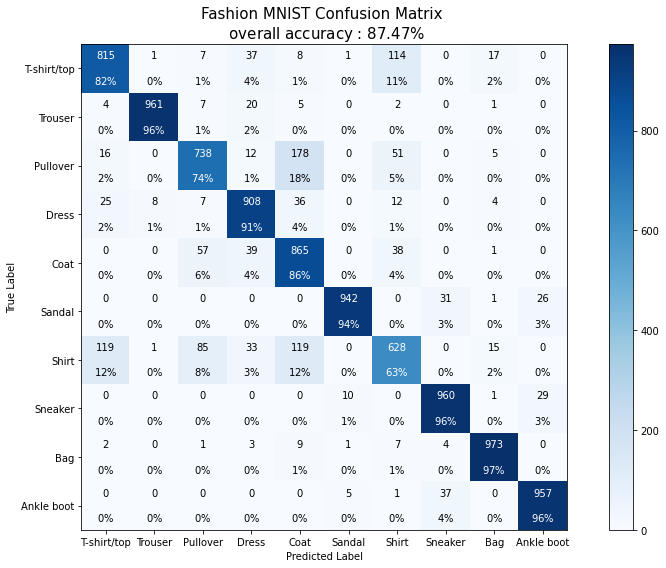

overall Test Accuracy : 87.47 %


In [32]:
y_true = fashion_mnist_y_test  # True labels
y_pred = fashion_mnist_y_test_pred # Predicted labels

num_classes = 10  # Fashion MNIST has 10 classes
confusion_mat = np.zeros((num_classes, num_classes), dtype=int)
total_correct_classes = [0 for i in range(num_classes)]

# Populate the confusion matrix
for t, p in zip(y_true, y_pred):
    # print(t,p)
    confusion_mat[t, p] += 1
    total_correct_classes[t] += 1

test_overall_accuracy = np.trace(confusion_mat)*100/len(y_true)

# Plot the confusion matrix
test_confusion_fig = plt.figure(figsize=(12, 8), facecolor='w')
plt.imshow(confusion_mat, interpolation='nearest', cmap='Blues')
plt.title(f"Fashion MNIST Confusion Matrix \n overall accuracy : ${test_overall_accuracy:.2f} \%$", size = 15)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

# Tick marks and labels
ticks = np.arange(num_classes)
plt.xticks(ticks, [fashion_mnist_label_to_class[i] for i in ticks])
plt.yticks(ticks, [fashion_mnist_label_to_class[i] for i in ticks])

# Annotate cells
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(confusion_mat[i, j]) + "\n\n" f"${confusion_mat[i, j]*100/total_correct_classes[i]:.0f} \% $",
                 ha="center", va="center",
                 color="white" if confusion_mat[i, j] > confusion_mat.max() / 2 else "black")

plt.tight_layout()
plt.show()

print(f"overall Test Accuracy : {test_overall_accuracy} %")

In [34]:
# wandb.login(key = "use_your_api")
# wandb.init(project="DA6401-fashion-mnist-assig-1", name="test_accuracy_best_hyper_2")
# wandb.log({"Test-confusion-matrix-2": wandb.Image(test_confusion_fig)})
# wandb.finish()

## Ques - 9 : Mnist Data

In [29]:
from helper_functions import mnist_loader
(mnist_train_x, mnist_train_y, mnist_val_x, mnist_val_y, mnist_x_test, mnist_y_test) = mnist_loader()

mnist_trainer_1_params = {'train_x' : mnist_train_x, 'train_y' : mnist_train_y, 'val_x' : mnist_val_x, 'val_y' : mnist_val_y, 
                        'epochs' : 10, 'n_hidden' : 5, 'hidden_size' : 128, 'lr' : 1e-3, 'optimizer' : "nadam", 'batch_size' : 64,}

mnist_trainer_2_params = {'train_x' : mnist_train_x, 'train_y' : mnist_train_y, 'val_x' : mnist_val_x, 'val_y' : mnist_val_y, 
                        'epochs' : 10, 'n_hidden' : 5, 'hidden_size' : 128, 'lr' : 1e-4, 'optimizer' : "nadam", 'batch_size' : 64,}

mnist_trainer_3_params = {'train_x' : mnist_train_x, 'train_y' : mnist_train_y, 'val_x' : mnist_val_x, 'val_y' : mnist_val_y, 
                        'epochs' : 10, 'n_hidden' : 5, 'hidden_size' : 128, 'lr' : 1e-3, 'optimizer' : "adam", 'batch_size' : 64,}

mnist_trainer_1 = automated_trainer(**mnist_trainer_1_params)

mnist_trainer_2 = automated_trainer(**mnist_trainer_2_params)

mnist_trainer_3 = automated_trainer(**mnist_trainer_3_params)

optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 

optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Nadam' 
lr : 0.0001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 

optimizer loaded with this setting : 
These are the specifications of the optimizer : 'Adam' 
lr : 0.001
beta1 : 0.9
beta2 : 0.999
epsilon : 1e-07
weight_decay : 0
dm : classical momentum
dv : cumulative square of gradients 

NN created successfully !, total params : 184.330K 



In [32]:
## Training 
mnist_params_results_1 = mnist_trainer_1.train_network()
print()
mnist_params_results_2 = mnist_trainer_2.train_network()
print()
mnist_params_results_3 = mnist_trainer_3.train_network()

train-progress-bar , epcoh : 1: 844it [00:10, 80.05it/s] 
train-progress-bar , epcoh : 2: 844it [00:12, 68.81it/s] 
train-progress-bar , epcoh : 3: 844it [00:08, 98.16it/s] 
train-progress-bar , epcoh : 4: 844it [00:09, 85.10it/s] 
train-progress-bar , epcoh : 5: 844it [00:08, 95.31it/s] 
train-progress-bar , epcoh : 6: 844it [00:07, 113.15it/s]
train-progress-bar , epcoh : 7: 844it [00:08, 97.28it/s] 
train-progress-bar , epcoh : 8: 844it [00:08, 101.30it/s]
train-progress-bar , epcoh : 9: 844it [00:08, 98.05it/s] 
train-progress-bar , epcoh : 10: 844it [00:07, 106.54it/s]


train-progress-bar , epcoh : 1: 844it [00:07, 118.46it/s]
train-progress-bar , epcoh : 2: 844it [00:06, 120.66it/s]
train-progress-bar , epcoh : 3: 844it [00:07, 120.47it/s]
train-progress-bar , epcoh : 4: 844it [00:09, 93.43it/s] 
train-progress-bar , epcoh : 5: 844it [00:09, 90.88it/s] 
train-progress-bar , epcoh : 6: 844it [00:14, 60.24it/s] 
train-progress-bar , epcoh : 7: 844it [00:09, 86.36it/s] 
train-progress-bar , epcoh : 8: 844it [00:07, 118.19it/s]
train-progress-bar , epcoh : 9: 844it [00:07, 119.67it/s]
train-progress-bar , epcoh : 10: 844it [00:09, 93.58it/s] 


train-progress-bar , epcoh : 1: 844it [00:07, 108.60it/s]
train-progress-bar , epcoh : 2: 844it [00:07, 120.28it/s]
train-progress-bar , epcoh : 3: 844it [00:06, 132.90it/s]
train-progress-bar , epcoh : 4: 844it [00:06, 121.72it/s]
train-progress-bar , epcoh : 5: 844it [00:07, 118.48it/s]
train-progress-bar , epcoh : 6: 844it [00:08, 98.91it/s] 
train-progress-bar , epcoh : 7: 844it [00:08, 97.81it/s] 
train-progress-bar , epcoh : 8: 844it [00:07, 110.38it/s]
train-progress-bar , epcoh : 9: 844it [00:08, 100.93it/s]
train-progress-bar , epcoh : 10: 844it [00:08, 93.83it/s] 


In [33]:
print(f"Validation accuracy for each config : \n config 1 : {mnist_params_results_1['Validation_accuracy'][-1]} \n config 2 : {mnist_params_results_2['Validation_accuracy'][-1]} \n config 3 : {mnist_params_results_3['Validation_accuracy'][-1]}")

Validation accuracy for each config : 
 config 1 : 0.9755 
 config 2 : 0.954 
 config 3 : 0.9693333333333334


In [38]:
### Test accuracy
mnist_x_test_data, mnist_y_test_encoded = mnist_x_test.reshape(mnist_x_test.shape[0],-1), one_hot_encode(mnist_y_test)

# for the first config
inference_mnist_1 = Inference_Loop(mnist_trainer_1.nn, mnist_x_test_data)
mnist_y_test_pred_1 = inference_mnist_1.make_inference(batch_size = 64)
config_1_test_accuracy = np.mean(mnist_y_test_pred_1 == mnist_y_test)*100

# for second config
inference_mnist_2 = Inference_Loop(mnist_trainer_2.nn, mnist_x_test_data)
mnist_y_test_pred_2 = inference_mnist_2.make_inference(batch_size = 64)
config_2_test_accuracy = np.mean(mnist_y_test_pred_2 == mnist_y_test)*100

# for the third config
inference_mnist_3 = Inference_Loop(mnist_trainer_3.nn, mnist_x_test_data)
mnist_y_test_pred_3 = inference_mnist_3.make_inference(batch_size = 64)
config_3_test_accuracy = np.mean(mnist_y_test_pred_3 == mnist_y_test)*100

print(f"Test accuracy for each config : \n config 1 : {config_1_test_accuracy:3f} \n config 2 : {config_2_test_accuracy:3f} \n config 3 : {config_3_test_accuracy:3f}")

inference-progress-bar: 157it [00:00, 628.76it/s]
inference-progress-bar: 157it [00:00, 581.94it/s]
inference-progress-bar: 157it [00:00, 801.57it/s]

Test accuracy for each config : 
 config 1 : 97.490000 
 config 2 : 95.630000 
 config 3 : 96.850000
